<a href="https://colab.research.google.com/github/lacykaltgr/quant/blob/main/quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup

In [2]:
import pandas as pd
import numpy as np

In [3]:
import glob
import os

quant_folder_location = "/content/drive/MyDrive/quant"
weather_prepared_file_path = quant_folder_location + "/weather_df.csv"
weather_prepared_file_path_pred = quant_folder_location + "/preds.csv"
county_location_file_path = quant_folder_location + "/agri/minnesota_county_location.csv"
county_agr_prod_file_path = quant_folder_location + "/agri/minnesota_county_yearly_agricultural_production.csv"
station_location_file_path = quant_folder_location + "/weather/minnesota_station_location.csv"

def station_weather_fp(station_name):
  return quant_folder_location + "/weather/minnesota_daily/" + str(station_name) + ".csv"

dir_path = quant_folder_location + "/weather/prediction_targets_daily"
pred_files = glob.glob(f'{dir_path}/*.csv')
pred_codes = [os.path.splitext(os.path.basename(file))[0] for file in pred_files]

# Prepare weather data


In [4]:
#átugrási lehetőség
weather_df = pd.read_csv(weather_prepared_file_path)
weather_df_pred = pd.read_csv(weather_prepared_file_path_pred)

<ipython-input-4-41ba97ddcf50>:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df = pd.read_csv(weather_prepared_file_path)


In [ ]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603227 entries, 0 to 603226
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  603227 non-null  int64  
 1   date        603227 non-null  object 
 2   avg         603227 non-null  float64
 3   min         603227 non-null  float64
 4   max         603227 non-null  float64
 5   rain        603227 non-null  float64
 6   code        603227 non-null  object 
 7   lat         603227 non-null  float64
 8   lon         603227 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 41.4+ MB


In [9]:
station_location_df = pd.read_csv(station_location_file_path)

station_weather_df_list = []
station_weather_df_list_pred = []

station_codes = np.unique(station_location_df.Code)
for code in station_codes:
  try:
      station_df = pd.read_csv(station_weather_fp(code), header=None, index_col=False, names=["date", "avg", "min", "max", "rain"])
      station_weather_df_list.append(station_df)
  except:
      station_codes.remove(code)
      print(f"Hibás/üres fájl: {code}")

for path in pred_files:
  try:
      station_df = pd.read_csv(path, header=None, index_col=False, names=["date", "avg", "min", "max", "rain"])
      station_weather_df_list_pred.append(station_df)
  except:
      pred_codes.remove(code)
      print(f"Hibás/üres fájl: {code}")

In [ ]:
from dateutil.relativedelta import relativedelta
import math

def fillnullvalues(station_weather_df_list):
  for station in station_weather_df_list:
    station["date"] = pd.to_datetime(station["date"])
    station["min"] = station["min"].interpolate(method="linear", limit=21)
    station["max"] = station["max"].interpolate(method="linear", limit=21)
    for index, record in station.iterrows():
      if math.isnan(record["min"]):
        for i in range(index, index+10*365+1, 365):
          if not math.isnan(station.iloc[i+365]["min"]):
            station.loc[index, "min"] = station.iloc[i+365]["min"]
            break
          else: 
            if not math.isnan(station.iloc[i-365]["min"]):
              station.loc[index, "min"] = station.iloc[i-365]["min"]
              break
      if math.isnan(record["max"]):
        for i in range(index, index+15*365+1, 365):
          if not math.isnan(station.iloc[i+365]["max"]):
            station.loc[index, "max"] = station.iloc[i+365]["max"]
            break
          else:
            if not math.isnan(station.iloc[i-365]["max"]):
              station.loc[index, "max"] = station.iloc[i-365]["max"]
              break
      if math.isnan(record["rain"]):
        i = index+365
        while i < len(station):
          if not math.isnan(station.iloc[i]["rain"]):
            station.loc[index, "rain"] = station.iloc[i]["rain"]
            break
          i += 365

fillnullvalues(station_weather_df_list)
fillnullvalues(station_weather_df_list_pred)

In [ ]:
#train
for i, (station_data, code) in enumerate(zip(station_weather_df_list, station_codes)):
  lat = station_location_df[station_location_df["Code"] == code ].Latitude.values[0]
  lon = station_location_df[station_location_df["Code"] == code ].Longitude.values[0]
  station_weather_df_list[i] = station_data.assign(code = code, lat = lat, lon = lon)
combined_weather_df = pd.concat(station_weather_df_list, axis=0)
combined_weather_df["rain"] = combined_weather_df["rain"].fillna(0)


#pred
for i, (station_data, code) in enumerate(zip(station_weather_df_list_pred, pred_codes)):
  lat = station_location_df["Latitude"].mean()
  lon = station_location_df["Longitude"].mean()
  station_weather_df_list_pred[i] = station_data.assign(code = code, lat = lat, lon = lon)
combined_weather_df_pred = pd.concat(station_weather_df_list_pred, axis=0)
combined_weather_df_pred["rain"] = combined_weather_df_pred["rain"].fillna(0)

In [ ]:
no_missing_weather_df = combined_weather_df[combined_weather_df["avg"].notnull()]
no_missing_weather_df_pred = combined_weather_df_pred[combined_weather_df_pred["avg"].notnull()]

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor

no_missing_weather_train_df = no_missing_weather_df.drop(["code", "rain"], axis=1)
no_missing_weather_train_df['year'] = no_missing_weather_train_df['date'].dt.year
no_missing_weather_train_df['month'] = no_missing_weather_train_df['date'].dt.month
no_missing_weather_train_df['day'] = no_missing_weather_train_df['date'].dt.day
no_missing_weather_train_df = no_missing_weather_train_df.drop("date", axis=1)

X_fill_avg = no_missing_weather_train_df.drop("avg", axis=1)
y_fill_avg = no_missing_weather_train_df["avg"]
X_avg_train, X_avg_test, y_avg_train, y_avg_test = train_test_split(X_fill_avg, y_fill_avg, test_size=0.1)
evaluation = [(X_avg_train, y_avg_train), (X_avg_test, y_avg_test)]

model = XGBRegressor(early_stopping_rounds=300)
model.fit(X_avg_train, y_avg_train, eval_set=evaluation, verbose=1)

[0]	validation_0-rmse:9.68728	validation_1-rmse:9.64328
[1]	validation_0-rmse:6.82424	validation_1-rmse:6.79457
[2]	validation_0-rmse:4.82778	validation_1-rmse:4.80614
[3]	validation_0-rmse:3.44450	validation_1-rmse:3.42746
[4]	validation_0-rmse:2.49699	validation_1-rmse:2.48285
[5]	validation_0-rmse:1.85949	validation_1-rmse:1.84593
[6]	validation_0-rmse:1.44466	validation_1-rmse:1.43006
[7]	validation_0-rmse:1.18733	validation_1-rmse:1.17154
[8]	validation_0-rmse:1.03552	validation_1-rmse:1.01825
[9]	validation_0-rmse:0.95053	validation_1-rmse:0.93205
[10]	validation_0-rmse:0.90439	validation_1-rmse:0.88534
[11]	validation_0-rmse:0.87927	validation_1-rmse:0.85994
[12]	validation_0-rmse:0.86566	validation_1-rmse:0.84611
[13]	validation_0-rmse:0.85793	validation_1-rmse:0.83848
[14]	validation_0-rmse:0.85323	validation_1-rmse:0.83388
[15]	validation_0-rmse:0.85009	validation_1-rmse:0.83088
[16]	validation_0-rmse:0.84759	validation_1-rmse:0.82849
[17]	validation_0-rmse:0.84556	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=300,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
def missing_avg(combined_weather_df):
  missing_avg_weather_df = combined_weather_df[combined_weather_df["avg"].isnull()]
  missing_avg_weather_prediction_X_df = missing_avg_weather_df.drop(["avg", "code", "rain"], axis=1)
  missing_avg_weather_prediction_X_df['year'] = missing_avg_weather_prediction_X_df['date'].dt.year
  missing_avg_weather_prediction_X_df['month'] = missing_avg_weather_prediction_X_df['date'].dt.month
  missing_avg_weather_prediction_X_df['day'] = missing_avg_weather_prediction_X_df['date'].dt.day
  missing_avg_weather_prediction_X_df = missing_avg_weather_prediction_X_df.drop("date", axis=1)

  missing_avg_weather_prediction_y_df = model.predict(missing_avg_weather_prediction_X_df)
  missing_avg_weather_df["avg"] = missing_avg_weather_prediction_y_df
  return missing_avg_weather_df

missing_avg_weather_df = missing_avg(combined_weather_df)
missing_avg_weather_df_pred = missing_avg(combined_weather_df_pred)

<ipython-input-81-be59528f7ff0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_avg_weather_df["avg"] = missing_avg_weather_prediction_y_df
<ipython-input-81-be59528f7ff0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_avg_weather_df["avg"] = missing_avg_weather_prediction_y_df


In [ ]:
weather_df = pd.concat([missing_avg_weather_df, no_missing_weather_df], axis=0)
weather_df_pred = pd.concat([missing_avg_weather_df_pred, no_missing_weather_df_pred], axis=0)

In [6]:
weather_df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525048 entries, 0 to 1525047
Data columns (total 9 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1525048 non-null  int64  
 1   date        1525048 non-null  object 
 2   avg         1525048 non-null  float64
 3   min         1525048 non-null  float64
 4   max         1525048 non-null  float64
 5   rain        1525048 non-null  float64
 6   code        1525048 non-null  object 
 7   lat         1525048 non-null  float64
 8   lon         1525048 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 104.7+ MB


In [ ]:
filename = 'weather_df.csv'
weather_df.to_csv('/content/drive/MyDrive/quant/' + filename)
weather_df_pred.to_csv('/content/drive/MyDrive/quant/' + 'preds.csv')

In [7]:
#normalizálás
from sklearn.preprocessing import MinMaxScaler

def normalize(weather_df):
  weather_df["avg"] = weather_df["avg"] - weather_df["avg"].mean() / weather_df["avg"].std()
  weather_df["min"] = weather_df["min"] - weather_df["min"].mean() / weather_df["min"].std()
  weather_df["max"] = weather_df["max"] - weather_df["max"].mean() / weather_df["max"].std()
  weather_df["rain"] = weather_df["rain"] - weather_df["rain"].mean() / weather_df["rain"].std()
  return weather_df

weather_df = normalize(weather_df)
weather_df_pred = normalize(weather_df_pred)

In [13]:
def to_weekly(station_codes, weather_df, haslocation):
  weather_stations = []
  for code in station_codes:
    station = dict()
    station["code"] = code
    if haslocation:
      station["lat"] = station_location_df[station_location_df["Code"] == code]["Latitude"].values[0]
      station["lon"] = station_location_df[station_location_df["Code"] == code]["Longitude"].values[0]

    weather_data = weather_df[weather_df['code'] == code].drop(["code", "lat", "lon"], axis=1)
    if 'Unnamed: 0' in weather_data.columns:
      weather_data = weather_data.drop('Unnamed: 0', axis=1)
    station["weather_daily"] = weather_data

    weather_data["date"] = pd.to_datetime(weather_data["date"])
    weather_data["year"] = weather_data['date'].dt.year
    weather_data['week'] = weather_data['date'].dt.isocalendar().week
    weather_data = weather_data.drop("date", axis=1)
    weekly_stats = weather_data.groupby(['year', 'week']).agg({'min': ['mean', 'std'], 'max': ['mean', 'std'], 'avg': ['mean', 'std'], 'rain': ['mean', 'std']})
    weekly_stats = weekly_stats.reset_index()
    weekly_stats.columns = ['year', 'week', 'min_mean', 'min_std', 'max_mean', 'max_std', 'avg_mean', 'avg_std', 'rain_mean', 'rain_std']
    weekly_stats = weekly_stats.fillna(0)

    if not weekly_stats["year"].isna().any():
      for y in np.unique(weekly_stats["year"]):
        year = weekly_stats[weekly_stats['year'] == y]
        for i in range(1, 53+1):
          if not (year['week'] == i).any():
            new_row = pd.DataFrame(weekly_stats[weekly_stats['week'] == i].mean()).transpose()
            new_row.columns = ['year', 'week', 'min_mean', 'min_std', 'max_mean', 'max_std', 'avg_mean', 'avg_std', 'rain_mean', 'rain_std']
            new_row["week"] = i
            new_row["year"] = y
            weekly_stats = pd.concat([weekly_stats, new_row], ignore_index=True, axis=0)
    station["weather_weekly"] = weekly_stats
    weather_stations.append(station)
  return weather_stations

weather_stations = to_weekly(station_codes, weather_df, True)
weather_stations_pred = to_weekly(pred_codes, weather_df_pred, False)
len(weather_stations)

97

# Prepare crop data

In [20]:
county_locations_df = pd.read_csv(county_location_file_path)
county_agr_prod_df = pd.read_csv(county_agr_prod_file_path, decimal=',')

In [21]:
county_agr_prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56268 entries, 0 to 56267
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Year                          56268 non-null  int64 
 1   County                        56268 non-null  object
 2   Commodity                     56268 non-null  object
 3   Crop                          56268 non-null  object
 4   ACRES HARVESTED               52674 non-null  object
 5   PRODUCTION, MEASURED IN BU    33231 non-null  object
 6   YIELD, MEASURED IN BU / ACRE  33232 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.0+ MB


In [22]:
county_agr_prod_df = county_agr_prod_df.rename(
    columns={'ACRES HARVESTED': 'acres', 
             'PRODUCTION, MEASURED IN BU': 'production', 
             'YIELD, MEASURED IN BU / ACRE': 'yield'})
county_agr_prod_df['acres'] = pd.to_numeric(county_agr_prod_df['acres'].astype(str).str.replace(',', '.'), errors='coerce')
county_agr_prod_df['production'] = pd.to_numeric(county_agr_prod_df['production'].astype(str).str.replace(',', '.'), errors='coerce')
county_agr_prod_df['yield'] = pd.to_numeric(county_agr_prod_df['yield'].astype(str).str.replace(',', '.'), errors='coerce')
county_agr_prod_df = county_agr_prod_df[county_agr_prod_df['acres'].notnull() | county_agr_prod_df['production'].notnull() | county_agr_prod_df['yield'].notnull()]

corn_df = county_agr_prod_df[county_agr_prod_df["Crop"] == "CORN, GRAIN"] #| county_agr_prod_df["Crop"] == "CORN, SILAGE"]
oat_df = county_agr_prod_df[county_agr_prod_df["Crop"] == "OATS"]
soybean_df = county_agr_prod_df[county_agr_prod_df["Crop"] == "SOYBEANS"]

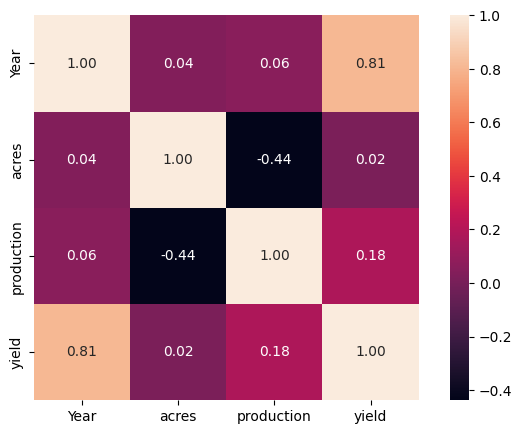

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plot = corn_df

plot = plot[plot['acres'].notnull() & plot['production'].notnull() & plot['yield'].notnull()]
numeric_columns = plot.select_dtypes(include=['int64', 'float64']).columns

cm = np.corrcoef(plot[numeric_columns].values.T)
fig = plt.gcf()
fig.set_size_inches(8, 5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=numeric_columns.values, xticklabels=numeric_columns.values)

In [24]:
county_locations_df['county_name'] = county_locations_df['county_name'].apply(lambda x: ' '.join(x.split()[:-1]).upper())
county_locations_df['county_name'] = county_locations_df['county_name'].str.replace('SAINT LOUIS', 'ST. LOUIS')

corn_df_extended = pd.merge(corn_df, county_locations_df, how='outer', left_on='County', right_on='county_name')
oat_df_extended = pd.merge(oat_df, county_locations_df, how='outer', left_on='County', right_on='county_name')
soybean_df_extended = pd.merge(soybean_df, county_locations_df, how='outer', left_on='County', right_on='county_name')

In [25]:
def clean(df):
  df_clean = df.drop(["County", "Commodity", "Crop", "county_name", "capital_name", "production", "acres"], axis=1)
  df_clean = df_clean[df_clean["yield"].notnull() & df_clean["county_latitude"].notnull() & df_clean["county_longitude"].notnull()]
  return df_clean

corn_df_clean = clean(corn_df_extended)
oat_df_clean = clean(oat_df_extended)
soybean_df_clean = clean(soybean_df_extended)

#Putting it all together...

In [26]:
corn_df_clean.info() #corn clean df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5014 entries, 0 to 5014
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              5014 non-null   float64
 1   yield             5014 non-null   float64
 2   county_latitude   5014 non-null   float64
 3   county_longitude  5014 non-null   float64
dtypes: float64(4)
memory usage: 195.9 KB


In [27]:
oat_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4735 entries, 0 to 4734
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              4735 non-null   float64
 1   yield             4735 non-null   float64
 2   county_latitude   4735 non-null   float64
 3   county_longitude  4735 non-null   float64
dtypes: float64(4)
memory usage: 185.0 KB


In [28]:
soybean_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4756 entries, 0 to 4845
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              4756 non-null   float64
 1   yield             4756 non-null   float64
 2   county_latitude   4756 non-null   float64
 3   county_longitude  4756 non-null   float64
dtypes: float64(4)
memory usage: 185.8 KB


In [29]:
from math import radians, sin, cos, sqrt, atan2

def distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km

    # Convert latitude and longitude to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # Calculate the differences between the two points
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Calculate the haversine of half the differences
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2

    # Calculate the great circle distance
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Calculate the distance in kilometers
    dist = R * c

    return dist


def distance_from_station(weather_station, lat, lon):
  return distance(weather_station["lat"], weather_station["lon"], lat, lon)


In [31]:
weather_staions = list(filter(lambda x: len(x["weather_weekly"]) != 0, weather_stations))
weather_staions_pred = list(filter(lambda x: len(x["weather_weekly"]) != 0, weather_stations_pred))

In [33]:
len(weather_stations_pred)

198

In [34]:
def to_feature_data(df_clean):
  data = []
  for _, y in df_clean.iterrows():
    yearly_data = dict()
    yearly_data["year"] = y["Year"]
    yearly_data["yield"] = y["yield"]
    county_lat = y["county_latitude"]
    county_lon = y["county_longitude"]
    stations = sorted(weather_stations, key=lambda s:distance_from_station(s, county_lat, county_lon))

    i = 0
    while distance_from_station(stations[i], county_lat, county_lon) < 120:
      station_weekly = stations[i]["weather_weekly"]
      yearly_data["weather"] = station_weekly[station_weekly["year"] == y["Year"]]
      if yearly_data["weather"].shape[0] == 53:
        data.append(yearly_data)
        break
      i += 1
  return data

def to_pred_data(weather_staions_pred):
  data = []
  meta = []
  yearss = list(map(lambda x: np.unique(x['weather_weekly']['year']), weather_staions_pred))
  for station, years in zip(weather_staions_pred, yearss):
    for year in years:
      yearly_data = dict()
      yearly_meta = dict()
      yearly_meta['year'] = year
      yearly_meta["code"] = station["code"]
      yearly_data["year"] = year
      station_weekly = station["weather_weekly"]
      yearly_data["weather"] = station_weekly[station_weekly["year"] == year].sort_values("week")
      yearly_data["weather"] = yearly_data["weather"].drop(["year", "week"], axis=1)
      data.append(yearly_data)
  return data, meta


corn_data = to_feature_data(corn_df_clean)
oat_data = to_feature_data(oat_df_clean)
soybean_data = to_feature_data(soybean_df_clean)

pred_data, pred_meta = to_pred_data(weather_stations_pred)

In [36]:
len(pred_data)

4714

In [ ]:
#valid_adatok = []
#for tav in range(10, 200, 5):
#  data = []
#  for _, y in corn_df_clean.iterrows():
#    yearly_data = dict()
#    yearly_data["year"] = y["Year"]
#    yearly_data["yield"] = y["yield"]
#    county_lat = y["county_latitude"]
#    county_lon = y["county_longitude"]
#    stations = sorted(weather_stations, key=lambda s:distance_from_station(s, county_lat, county_lon))
#
#    i = 0
#    while distance_from_station(stations[i], county_lat, county_lon) < tav:
#      station_weekly = stations[i]["weather_weekly"]
#      yearly_data["weather"] = station_weekly[station_weekly["year"] == y["Year"]]
#      if not yearly_data['weather'].empty:
#        data.append(yearly_data)
#        break
#      i += 1
    
#  valid_adatok.append(len(data))

In [ ]:
#import matplotlib.pyplot as plt
#x_values = [10+x*5 for x in range(len(valid_adatok))]
#plt.xticks(range(len(valid_adatok)), x_values, rotation=90)
#plt.plot(valid_adatok)

# Train and validation set


In [49]:
def clean_data(data, split_ratio = 0.9):
  
  X_weather = []
  for sample in data:
      weather_data = sample["weather"].to_numpy()
      X_weather.append(weather_data)

  X_year = np.array(list(map(lambda s: s["year"], data)))

  if split_ratio == 1:
    return X_weather, X_year

  y = np.array(list(map(lambda s: s["yield"], data)))
  
  split = int(len(data)*split_ratio)

  X_weather_train = np.stack(X_weather[:split])
  X_weather_val = np.stack(X_weather[split:])
  X_year_train = X_year[:split]
  X_year_val = X_year[split:]
  y_train = y[:split]
  y_val = y[split:]
  return X_weather_train, X_weather_val, X_year_train, X_year_val, y_train, y_val, y


X_weather_train_corn, X_weather_val_corn, X_year_train_corn, X_year_val_corn, y_train_corn, y_val_corn, _ = clean_data(corn_data)
X_weather_train_oat, X_weather_val_oat, X_year_train_oat, X_year_val_oat, y_train_oat, y_val_oat, _ = clean_data(oat_data)
X_weather_train_soybean, X_weather_val_soybean, X_year_train_soybean, X_year_val_soybean, y_train_soybean, y_val_soybean, _ = clean_data(soybean_data)

X_weather, X_year = clean_data(pred_data, 1)

# LSTM model

In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model

seq_input = Input(shape=(52, 8))
int_input = Input(shape=(1,))

lstm1 = LSTM(256, return_sequences=True, kernel_regularizer="l2")(seq_input)
drop1 = Dropout(0.2)(lstm1)
lstm2 = LSTM(128, return_sequences=False, kernel_regularizer="l2")(drop1)
bn1 = BatchNormalization()(lstm2)
drop2 = Dropout(0.2)(bn1)

concat = Concatenate()([drop2, int_input])

dense1 = Dense(32, activation='relu')(concat)
dense2 = Dense(1, activation='linear')(dense1)

model = Model(inputs=[seq_input, int_input], outputs=dense2)

model.compile(optimizer='adam', loss='mean_squared_error')

In [51]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 52, 8)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 52, 256)      271360      ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 52, 256)      0           ['lstm[0][0]']                   
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          197120      ['dropout[0][0]']                
                                                                                              

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

early_stopping = EarlyStopping(monitor='loss', restore_best_weights=True, patience=10)
tb = TensorBoard(log_dir='content/logs', histogram_freq=1, write_graph=True)

model.fit([X_weather_train_corn, X_year_train_corn], y_train_corn, validation_data=([X_weather_val_corn, X_year_val_corn], y_val_corn), epochs=1000, batch_size=64, callbacks=[early_stopping])

Epoch 1/1000
32/32 [==============================] - 6s 38ms/step - loss: 5176.8057 - val_loss: 2512.4248
Epoch 2/1000
32/32 [==============================] - 0s 11ms/step - loss: 1003.4471 - val_loss: 1395.1454
Epoch 3/1000
32/32 [==============================] - 0s 11ms/step - loss: 699.6997 - val_loss: 1297.8213
Epoch 4/1000
32/32 [==============================] - 0s 10ms/step - loss: 552.3714 - val_loss: 1199.7693
Epoch 5/1000
32/32 [==============================] - 0s 11ms/step - loss: 500.2223 - val_loss: 1099.4658
Epoch 6/1000
32/32 [==============================] - 0s 11ms/step - loss: 488.2756 - val_loss: 778.6960
Epoch 7/1000
32/32 [==============================] - 0s 11ms/step - loss: 466.7027 - val_loss: 906.3442
Epoch 8/1000
32/32 [==============================] - 0s 11ms/step - loss: 437.7279 - val_loss: 614.1481
Epoch 9/1000
32/32 [==============================] - 0s 11ms/step - loss: 394.5049 - val_loss: 995.3036
Epoch 10/1000
32/32 [===========================

In [ ]:
%load_ext tensorboard
%tensorboard --logdir content/logs --load_fast=fals

In [ ]:
loss = model.evaluate([X_weather_val_corn, X_year_val_corn], y_val_corn)
print('Validation loss:', loss)

# XGBoost model
For corn yield prediction at first...

In [66]:
from xgboost import XGBRegressor
import numpy as np

def to_vector(data, split_ratio = 0.9):
  if split_ratio == 1:
    X_weather, X_year = clean_data(data, split_ratio = split_ratio)
    X = []
    for i in range(len(X_weather)):
      X.append(np.append(X_year[i], np.array(X_weather[i]).flatten()))
    X = pd.DataFrame(np.stack(X))
    return X

  X_weather_train, X_weather_val, X_year_train, X_year_val, y_train, y_val, y = clean_data(data, split_ratio = split_ratio)
  X = []
  X_train = []
  for i in range(len(X_weather_train)):
    X.append(np.append(X_year_train[i], np.array(X_weather_train[i]).flatten()))
    X_train.append(np.append(X_year_train[i], np.array(X_weather_train[i]).flatten()))
  X_train = np.stack(X_train)

  X_val = []
  for i in range(len(X_weather_val)):
    X.append(np.append(X_year_val[i], np.array(X_weather_val[i]).flatten()))
    X_val.append(np.append(X_year_val[i], np.array(X_weather_val[i]).flatten()))

  X_val = np.stack(X_val)
  X = pd.DataFrame(np.stack(X)).astype(float)
  y = pd.DataFrame(y).astype(float)
  return X, X_train, X_val, y, y_train, y_val



X_corn, X_train_corn, X_val_corn, y_corn, y_train_corn, y_val_corn = to_vector(corn_data, 0.9)
X_oat, X_train_oat, X_val_oat, y_oat, y_train_oat, y_val_oat = to_vector(oat_data, 0.9)
X_soybean, X_train_soybean, X_val_soybean, y_soybean, y_train_soybean, y_val_soybean = to_vector(soybean_data, 0.9)

X = to_vector(pred_data, 1)

In [53]:
param_grid = {'n_estimators': [ 1000, 1500, 1750, 2000, 2500, 3000],
   "learning_rate": [0.03, 0.04, 0.045, 0.05,0.065 ],
   "max_depth": [ 1, 2, 3, 4, 5, 6, 8],
   "min_child_weight": [3, 4, 5, 6, 7],
   "gamma": [ 0.3, 0.4, 0.5, 0.6, 0.7],
   "colsample_bytree": [ 0.1, 0.2, 0.25, 0.3]
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

RS_XGB = RandomizedSearchCV(estimator=XGBRegressor(early_stopping_rounds=20), param_distributions=param_grid, n_iter=15, cv=5 ,n_jobs=-1, random_state=0)
RS_XGB.fit(X_train_corn, y_train_corn, eval_set=[(X_train_corn,y_train_corn),(X_val_corn,y_val_corn)],verbose=0)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=20,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=No...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.1, 0.3],
                                        'gamma': [0.3, 0.7],
                                        'learning_rate': [0.03, 0.08],
                                        'max_depth': [3, 8],
                                        'min_child_weight': [3, 7],
                                        'n_estimators': [1000, 1500, 2000]},
                   random_state=0)

In [72]:
params = {'n_estimators': 2000,
'min_child_weight': 7,
'max_depth': 3,
'learning_rate': 0.03,
'gamma': 0.3,
'colsample_bytree': 0.3}

In [73]:
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.model_selection import KFold


corn_models = []
scores = []
feature_importances = []

skf = KFold(n_splits=30, shuffle=True, random_state=0)
for fold, (train_idx, val_idx) in enumerate(skf.split(X_corn, y_corn)):
    
    X_train_corn, y_train_corn = X_corn.iloc[train_idx], y_corn.iloc[train_idx]
    X_valid_corn, y_valid_corn = X_corn.iloc[val_idx], y_corn.iloc[val_idx]
    evaluation = [(X_train_corn, y_train_corn), (X_valid_corn, y_valid_corn)]

    model = XGBRegressor(**params, n_jobs=-1, early_stopping_rounds=30)
    model.fit(X_train_corn, y_train_corn, eval_set=evaluation, verbose=0)

    val_preds = model.predict(X_valid_corn)
    val_score = mean_absolute_error(y_valid_corn, val_preds)
    best_iter = model.best_iteration

    feature_importances.append({i: j for i in model.feature_names_in_ for j in model.feature_importances_ })
    print(f' mae :{val_score:.5f}    best iteration  :{best_iter}')
    
    if (val_score < 11):
        scores.append(val_score)
        corn_models.append(model)
        
        
mean_val_auc = np.array(scores).mean(0)
print(f'MAE:  {mean_val_auc}')

 mae :13.42504    best iteration  :680
 mae :11.81891    best iteration  :824
 mae :11.57058    best iteration  :957
 mae :12.00274    best iteration  :650
 mae :11.50440    best iteration  :749
 mae :13.37398    best iteration  :599


KeyboardInterrupt: ignored

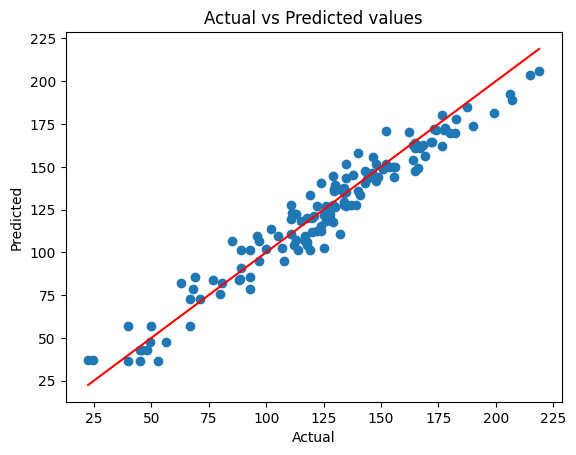

In [ ]:
import matplotlib.pyplot as plt

preds_corn = []
for model in xgb_models:
    preds_corn.append(model.predict(X_val_corn))

# take the mean of the test predictions
mean_test_preds_corn = np.mean(preds_corn, axis=0)

# Plot the actual vs predicted values
plt.scatter(y_val_corn, mean_test_preds_corn)
plt.plot(np.linspace(min(y_val_corn), max(y_val_corn)), np.linspace(min(y_val_corn), max(y_val_corn)), color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted values')
plt.show()

# Oats


In [ ]:
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.model_selection import KFold

oat_models = []
scores = []
feature_importances = []

skf = KFold(n_splits=20, shuffle=True, random_state=0)
for fold, (train_idx, val_idx) in enumerate(skf.split(X_oat, y_oat)):
    
    X_train_oat, y_train_oat = X_oat.iloc[train_idx], y_oat.iloc[train_idx]
    X_valid_oat, y_valid_oat = X_oat.iloc[val_idx], y_oat.iloc[val_idx]
    evaluation = [(X_train_oat, y_train_oat), (X_valid_oat, y_valid_oat)]

    model = XGBRegressor(**params, n_jobs=-1, early_stopping_rounds=30)
    model.fit(X_train_oat, y_train_oat, eval_set=evaluation, verbose=0)

    val_preds = model.predict(X_valid_oat)
    val_score = mean_absolute_error(y_valid_oat, val_preds)
    best_iter = model.best_iteration

    feature_importances.append({i: j for i in model.feature_names_in_ for j in model.feature_importances_ })
    print(f'mae: {val_score:.5f}    best iteration: {best_iter}')
    
    if (val_score < 11):
        scores.append(val_score)
        oat_models.append(model)
        
mean_val_auc = np.array(scores).mean(0)
print(f'MAE: {mean_val_auc}')

In [ ]:
import matplotlib.pyplot as plt

preds_oat = []
for model in oat_models:
    preds_oat.append(model.predict(X_valid_oat))

# take the mean of the test predictions
mean_test_preds_oat = np.mean(preds_oat, axis=0)

# Plot the actual vs predicted values
plt.scatter(y_valid_oat, mean_test_preds_oat)
plt.plot(np.linspace(min(y_valid_oat), max(y_valid_oat)), np.linspace(min(y_valid_oat), max(y_valid_oat)), color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted values for Oat')
plt.show()

In [ ]:

    for meta, pred in zip(preds_meta, mean_test_preds_corn):
        f.write(f'"{meta["code"]}",{meta["year"]},"CORN",{pred}\n')

# Soybeans

In [ ]:
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.model_selection import KFold

soybean_models = []
scores = []
feature_importances = []

skf = KFold(n_splits=20, shuffle=True, random_state=0)
for fold, (train_idx, val_idx) in enumerate(skf.split(X_soybean, y_soybean)):
    
    X_train_soybean, y_train_soybean = X_soybean.iloc[train_idx], y_soybean.iloc[train_idx]
    X_valid_soybean, y_valid_soybean = X_soybean.iloc[val_idx], y_soybean.iloc[val_idx]
    evaluation = [(X_train_soybean, y_train_soybean), (X_valid_soybean, y_valid_soybean)]

    model = XGBRegressor(**params, n_jobs=-1, early_stopping_rounds=30)
    model.fit(X_train_soybean, y_train_soybean, eval_set=evaluation, verbose=0)

    val_preds = model.predict(X_valid_soybean)
    val_score = mean_absolute_error(y_valid_soybean, val_preds)
    best_iter = model.best_iteration

    feature_importances.append({i: j for i in model.feature_names_in_ for j in model.feature_importances_ })
    print(f'mae: {val_score:.5f}    best iteration: {best_iter}')
    
    if (val_score < 11):
        scores.append(val_score)
        soybean_models.append(model)
        
mean_val_auc = np.array(scores).mean(0)
print(f'MAE: {mean_val_auc}')

In [ ]:
preds_soybean = []
for model in soybean_models:
    preds_soybean.append(model.predict(X_valid_soybean))

# take the mean of the test predictions
mean_test_preds_soybean = np.mean(preds_soybean, axis=0)

# Plot the actual vs predicted values
plt.scatter(y_valid_soybean, mean_test_preds_soybean)
plt.plot(np.linspace(min(y_valid_soybean), max(y_valid_soybean)), np.linspace(min(y_valid_soybean), max(y_valid_soybean)), color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted values for Soybean')
plt.show()

# Exporting the predictions

In [ ]:
with open('output.csv', 'w') as f:
    f.write('"Target location","Year","Crop","Predicted yield (BU/acre)"\n')
    
    for meta, pred in zip(preds_meta, mean_test_preds_corn):
        f.write(f'"{meta["code"]}",{meta["year"]},"CORN",{pred}\n')
    for meta, pred in zip(preds_meta, mean_test_preds_oat):
        f.write(f'"{meta["code"]}",{meta["year"]},"OAT",{pred}\n')
    for meta, pred in zip(preds_meta, mean_test_preds_soybean):
        f.write(f'"{meta["code"]}",{meta["year"]},"SOYBEAN",{pred}\n')